# Predicting Newsletter Subscription in PLAICraft Using K-NN Classification

### Project Final Report (Group 40)

**Annie Ma 87140554
<br>Kai Shih 52570777
<br>Chuqiao Zhou 69441996
<br>Charlie Gatley 74748740**


## Introduction

### Background
Understanding player behaviour is essential when running a game to maintain the server and increase its audience. Thus, game studios record player data to understand, effectively communicate and retain players. A UBC CS research group led by Professor Frank Wood set up a MineCraft server and recorded players’ in-game actions and other demographic data to further improve their player attraction. The collected data can then be further analyzed to target non-subscribers to their newsletter, and gain an understanding of who is likely to stay in communication with the server project. However, not all players choose to subscribe, even some who are very active on the platform. Finding out which users are more or less likely to subscribe can help developers design better promotional strategies and increase overall subscription rates.

### Question
The question we aimed to answer is <br>**“Can we predict whether or not someone will subscribe to the newsletter based on how much they've played in PLAICraft (`played_hours`) and self-reported Minecraft experience? (`experience`)”** Since `subscribe` is a categorical variable, we approached this question by using K-NN classification and selecting a model with high recall in order to accurately predict non-subscribers.

### Dataset
The datasets given by the CS research group were collected from players engaging with the PLAICraft server over a defined period. 

To explore this question, we used a dataset titled `players.csv`, which contains 196 observations of individual PLAICraft users and 7 variables, which are listed below:
- Player experience level: `experience`
- Subscription status: `subscribe`
- User email: `hashed_Email`
- Total hours played by a user (in hours): `played_hours`
- Player name: `name`
- Player's gender identity: `gender`
- Player age: `age`

| Feature      | Type 
|--------------|-----------|
| experience | Character |
| subscribe | Logical |
| hashed_Email | Character |
| played_hours | Double |
| name | Character |
| gender | Character |
| age | Double |

For the purposes of our project, `experience` will have to be a **Double** variable and `subscribe` will have to be a **Factor** variable.

## Methods & Results

In [1]:
#Loading libraries
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(ggplot2)
library(tidymodels)
library(dplyr)
library(themis)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Reading data using relative path
set.seed(12)

players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### Exploratory Visualization

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


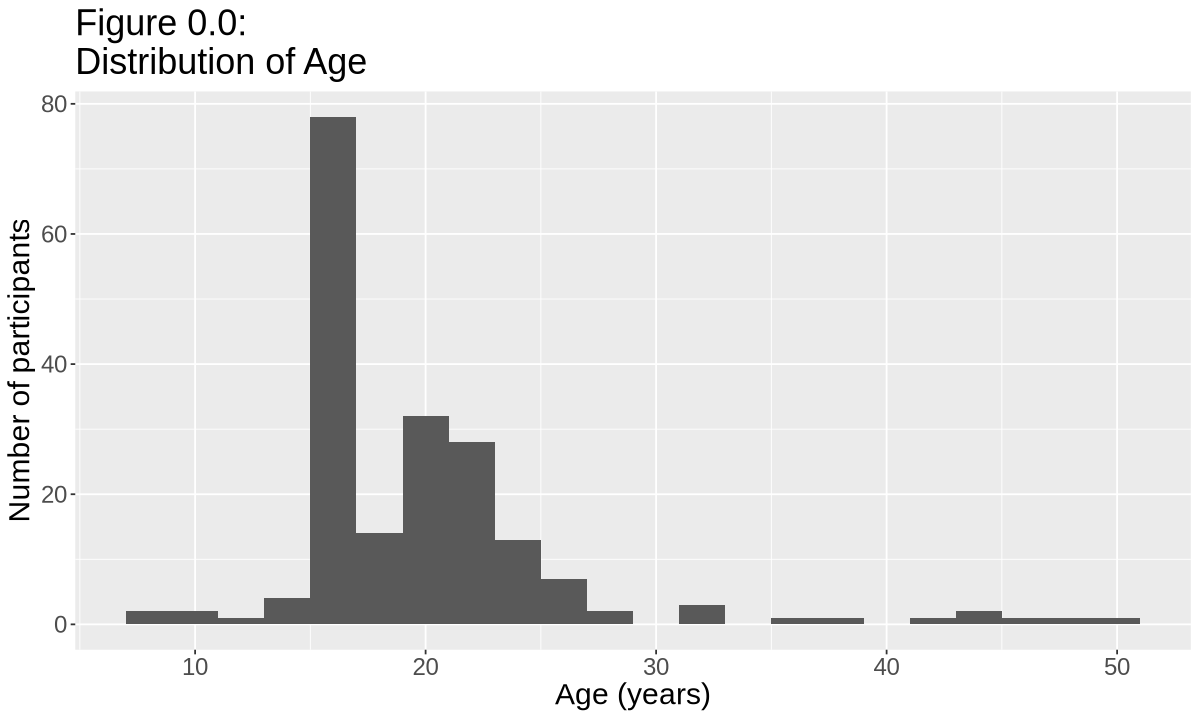

In [3]:
options(repr.plot.width = 10, repr.plot.height = 6)
age_plot <- ggplot(players, aes(x = Age)) +
  geom_histogram(binwidth = 2) +
  labs(title = "Figure 0.0:\nDistribution of Age",
       x = "Age (years)",
       y = "Number of participants") +
       theme(text = element_text(size = 18))
age_plot

**Figure 0.0:** We chose this visualization as were were considering using `Age` as a predictive variable; however, we wanted to ensure that player ages were spread out and therefore likely reported accurately. This visualization shows us that there is a huge spike of players at the age of 17. We thought that perhaps 17 was listed as a default age, and thus decided not to pursue it in our analysis.

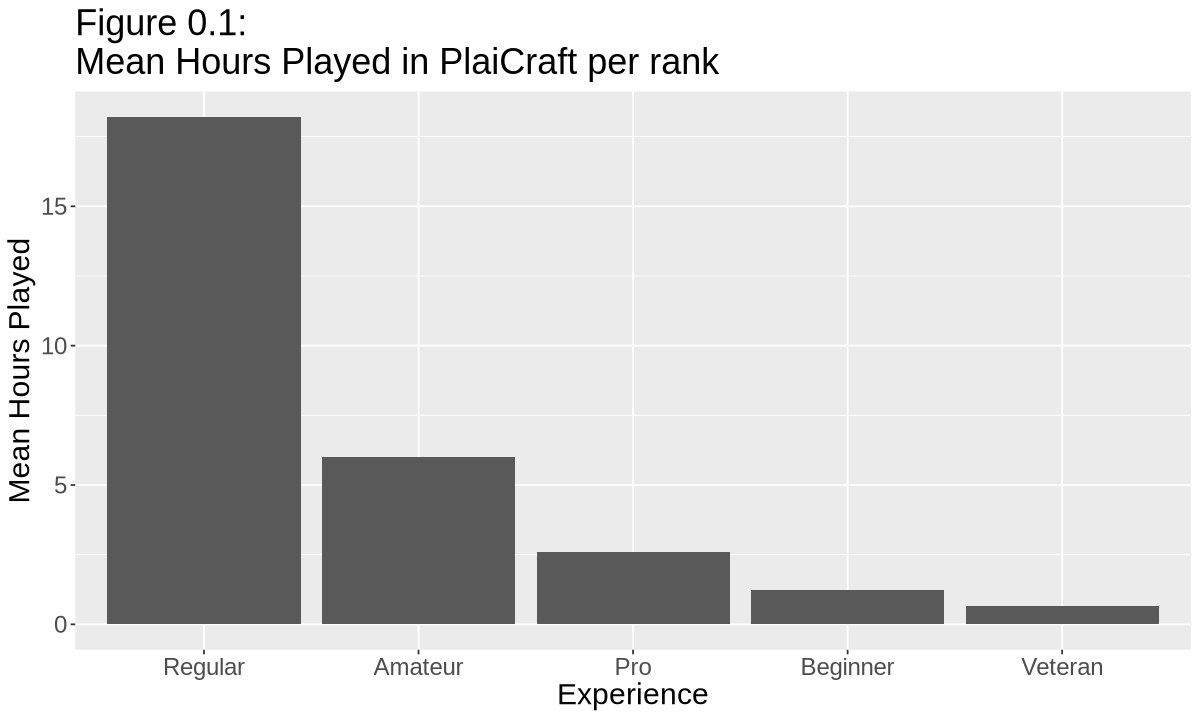

In [4]:
options(repr.plot.width = 10, repr.plot.height = 6)
mean_hours_played <- players |>
    group_by(experience) |>
    summarize(mean_hours_played = mean(played_hours))

exp_vs_hrs_plot <- mean_hours_played |>
    ggplot(aes(x = fct_reorder(experience, mean_hours_played, .desc = TRUE), y = mean_hours_played)) +
    geom_bar(stat = "identity") + 
    labs(x = "Experience", y = "Mean Hours Played", title = "Figure 0.1:\nMean Hours Played in PlaiCraft per rank") +
    theme(text = element_text(size = 18))
exp_vs_hrs_plot

**Figure 0.1:** This visualization shows us that players with middling experience in MineCraft are most likely to log the most hours in the project. Thus, they may be the most likely to subscribe to a newsletter if played_hours is related to subscription. We chose these variables in the hopes that we would notice a correlation between `subscription` and `played_hours`, in which case `experience` may also play a role.

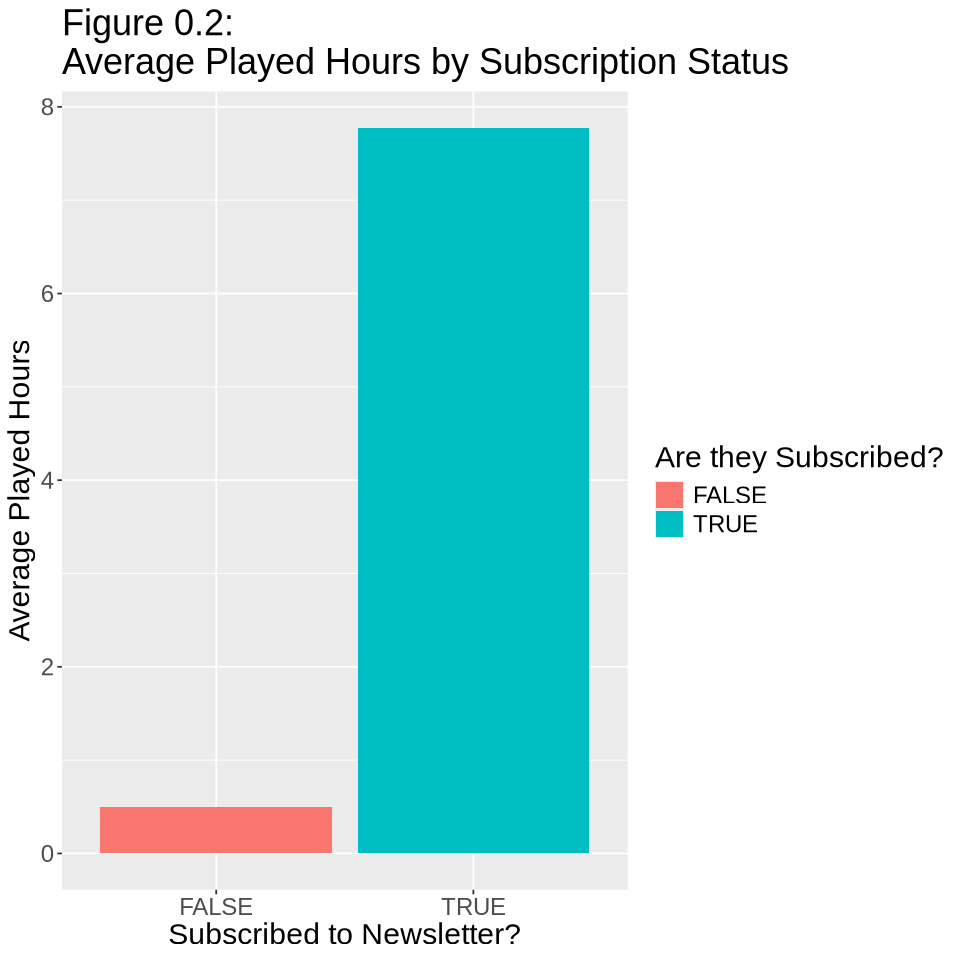

In [5]:
options(repr.plot.width = 8, repr.plot.height = 8)
hours_played_avg <- players |>
  group_by(subscribe) |>
  summarise(mean_hours = mean(played_hours, na.rm = TRUE))

hours_vs_subscribe_plot <- ggplot(hours_played_avg, aes(x = subscribe, y = mean_hours, fill = subscribe)) +
  geom_bar(stat = "identity") +
  labs(title = "Figure 0.2:\nAverage Played Hours by Subscription Status",
    x = "Subscribed to Newsletter?",
    y = "Average Played Hours",
    fill = "Are they Subscribed?") +
    theme(text = element_text(size = 18))
hours_vs_subscribe_plot

**Figure 0.2:** This visualization shows us that, indeed, subscribers play on average much more than non-subscribers. Combining this visualization with **Figure 0.1**, we can hypothesize that `experience` and `played_hours` contribute to subscription status.

### Modify The Players Data Set
- We modified the data set by selecting only the `subscribe`, `played_hours`, and `experience` columns since they’re the only variables we’re interested in. 
- However, since the experience column was originally a character (chr), we modified it using the `mutate` function and converted it into numeric (dbl) levels. Each experience level is assigned a number: Beginner = 1, Amateur = 2, Regular = 3, Pro = 4, Veteran = 5.
- In order to ensure we can use K-NN classification, our categorical variable `subscribe` must be converted into a factor variable.

In [6]:
#Data wrangling in preparation for classification
set.seed(12)

mod_players <- players |>
                select (subscribe, played_hours, experience) |>
                mutate (subscribe = as_factor(subscribe),
                        experience = recode(experience, Beginner = 1, Amateur = 2, Regular = 3, Pro = 4, Veteran = 5)) 
mod_players

subscribe,played_hours,experience
<fct>,<dbl>,<dbl>
TRUE,30.3,4
TRUE,3.8,5
FALSE,0.0,5
⋮,⋮,⋮
FALSE,0.0,2
FALSE,2.3,2
TRUE,0.2,4


### K-nn Tuning, Upsample & Accuracy Plot
- We used `set.seed(12)` in order to maintain reproducibility.
- In this section, we tune our data using the k-nn classification method and apply the `up_sample` function to balance the weight of the predictor variables
- We performed 5-fold cross-validation and tuned for k, with the number of neighbours ranging from 2 to 100, increasing by one each time.
- In the end, we plotted the accuracy versus the number of neighbours. However, we found that accuracy plot didn’t help much in determining the best value for k.
- The plot didn’t show a clear trend or peak that would guide us to pick one value over the others, so it didn’t provide helpful information for the final model selection.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5175041,5,0.03025870,Preprocessor1_Model01
2,roc_auc,binary,0.5217339,5,0.02833102,Preprocessor1_Model01
3,accuracy,binary,0.4361084,5,0.04112917,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,roc_auc,binary,0.4969968,5,0.04611618,Preprocessor1_Model98
100,accuracy,binary,0.5015928,5,0.06433796,Preprocessor1_Model99
100,roc_auc,binary,0.4894365,5,0.04309054,Preprocessor1_Model99


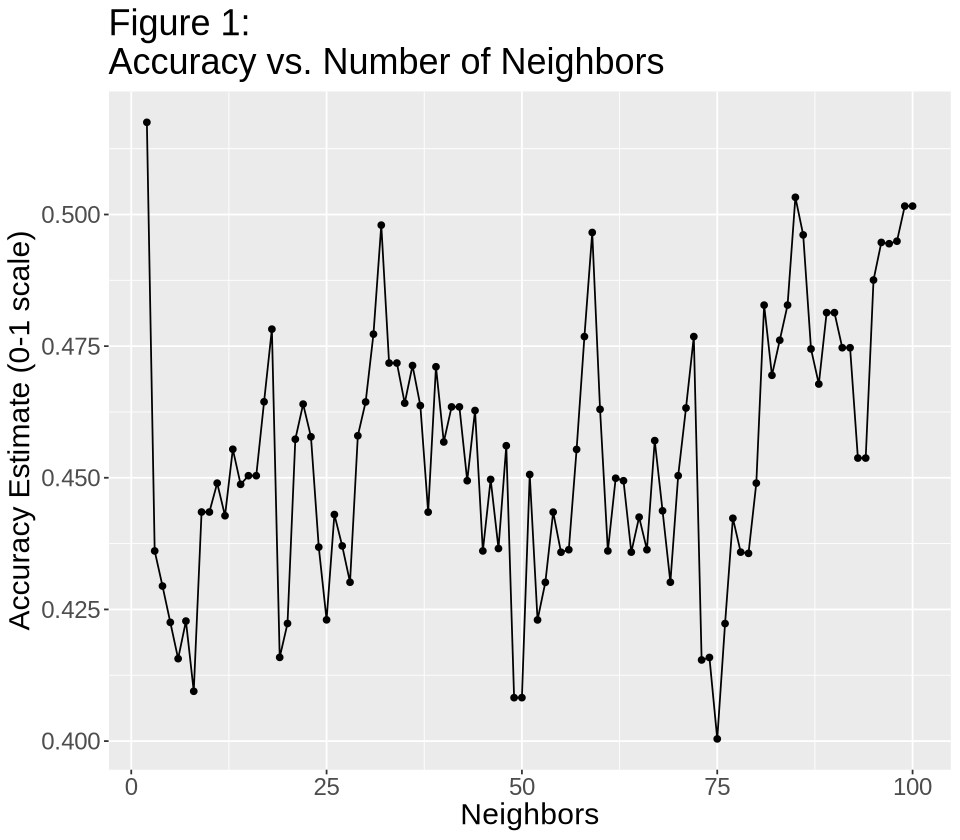

In [7]:
# K-nn Tuning (with cross-validation) + upsampling 
set.seed(12)
players_split <- mod_players |> 
                    initial_split (prop = 0.75, strata = subscribe) 

players_training <- training (players_split)
players_testing <- testing (players_split)

recipe_with_step <- recipe(subscribe ~ ., data = players_training) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors()) |>
                        step_upsample (subscribe , over_ratio = 1) 

knn_spec_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

knn_grid <- tibble(neighbors = seq(from = 2, to = 100, by = 1))

knn_results <- workflow() |>
                  add_recipe(recipe_with_step) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples = vfold, grid = knn_grid)|>
                  collect_metrics()

knn_results
# Fix issue with extracting neighbors and mean accuracy
accuracies <- knn_results |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean = mean) |>  # Ensure correct column selection
                  mutate(neighbors = as.numeric(neighbors), mean = as.numeric(mean))

# Plot accuracy vs. number of neighbors
options(repr.plot.height = 7, repr.plot.width = 8)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", 
                       y = "Accuracy Estimate (0-1 scale)",
                       title = "Figure 1:\nAccuracy vs. Number of Neighbors") +
                  theme(text = element_text(size = 18))
             
cross_val_plot

**Figure 1:** This visualization shows how the accuracy metric changes dependent on our value for *k*, between 2 and 100 neighbours. The accuracy estimate represents the ratio of correct to total guesses. As our `accuracy` results are both ambiguous and don't best predict *non-subscribers*, we decided to use a different evaluation metric to answer our focus question.

### Alternative Method
- From the above analysis, we realized that using accuracy as an evaluation metric doesn't give us a clear indicator of which K-value we should use, which suggests that accuracy is not thte best way to answer this question.
- However, we know there is not a specfic function that can automatically calculate the recall and precision of each neighbours, therefore, we calculated each neighbours manually to determine which k to use.
- we caculated k = 2, 3, 4, 6, 10, which allowed us to notice trends between number of neighbours and precision/recall.
- for each value for k, we produced a confusion matrix to see the count for each correct and incorrect prediction.

In [8]:
set.seed(12)
precision_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

# for 2 neighbors
knn_2 <- nearest_neighbor (weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_2 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_2) |>
    fit(data = players_training)

predictions_2 <- predict (fit_2, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_2 <- predictions_2 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_2 <- predictions_2 |>
    conf_mat (truth = subscribe, estimate = .pred_class) 

conf_mat_2

          Truth
Prediction FALSE TRUE
     FALSE    12   28
     TRUE      1    8

In [9]:
set.seed(12)
#for 4 neighbors

knn_4 <- nearest_neighbor (weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_4 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_4) |>
    fit(data = players_training)

predictions_4 <- predict (fit_4, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_4 <- predictions_4 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_4 <- predictions_4 |>
    conf_mat (truth = subscribe, estimate = .pred_class)

conf_mat_4

          Truth
Prediction FALSE TRUE
     FALSE    10   26
     TRUE      3   10

In [10]:
set.seed(12)
#for 6 neighbors

knn_6 <- nearest_neighbor (weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_6 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_6) |>
    fit(data = players_training)

predictions_6 <- predict (fit_6, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_6 <- predictions_6 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_6 <- predictions_6 |>
    conf_mat (truth = subscribe, estimate = .pred_class)
conf_mat_6

          Truth
Prediction FALSE TRUE
     FALSE     9   23
     TRUE      4   13

In [11]:
set.seed(12)
#for 10 neighbors

knn_10 <- nearest_neighbor (weight_func = "rectangular", neighbors = 10) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

fit_10 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_10) |>
    fit(data = players_training)

predictions_10 <- predict (fit_10, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_10 <- predictions_10 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_10 <- predictions_10 |>
    conf_mat (truth = subscribe, estimate = .pred_class)

conf_mat_10

          Truth
Prediction FALSE TRUE
     FALSE     4   16
     TRUE      9   20

In [12]:
set.seed(12)
#quantifying precision and recall

precision_2 <- 10/(10 + 21)
recall_2 <- 10/(10 + 3)

precision_3 <- 5/(5 + 18)
recall_3 <- 5/(5 + 8)

precision_4 <- 7/(7 + 21)
recall_4 <- 7/(7 + 6)

precision_6 <- 7/(7 + 19)
recall_6 <- 7/(7 + 6)

precision_10 <- 4/(4 + 10)
recall_10 <- 4/(4 + 9)

metrics_df <- tibble("k" = c(2, 3, 4, 6, 10), 
                     "precision" = c(precision_2, precision_3, precision_4, precision_6, precision_10),
                     "recall" = c(recall_2, recall_3, recall_4, recall_6, recall_10))
metrics_df

max_recall <- metrics_df |>
    select(k, recall) |>
    arrange(desc(recall)) |>
    slice(1) 
max_recall

k,precision,recall
<dbl>,<dbl>,<dbl>
2,0.3225806,0.7692308
3,0.2173913,0.3846154
4,0.2500000,0.5384615
6,0.2692308,0.5384615
10,0.2857143,0.3076923


k,recall
<dbl>,<dbl>
2,0.7692308


In [13]:
set.seed(12)

optimal_k <- 2

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) |>
    set_engine("kknn") |>
    set_mode("classification")

final_fit <- workflow() |>
    add_recipe(precision_recipe) |>
    add_model(final_spec) |>
    fit(data = players_training)

final_preds <- predict(final_fit, new_data = players_testing) |>
    bind_cols(players_testing)

final_accuracy <- final_preds |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

final_matrix <- final_preds |>
    conf_mat (truth = subscribe, estimate = .pred_class)

final_matrix
final_accuracy

          Truth
Prediction FALSE TRUE
     FALSE    12   28
     TRUE      1    8

[1] 0.4081633

## Visualization

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


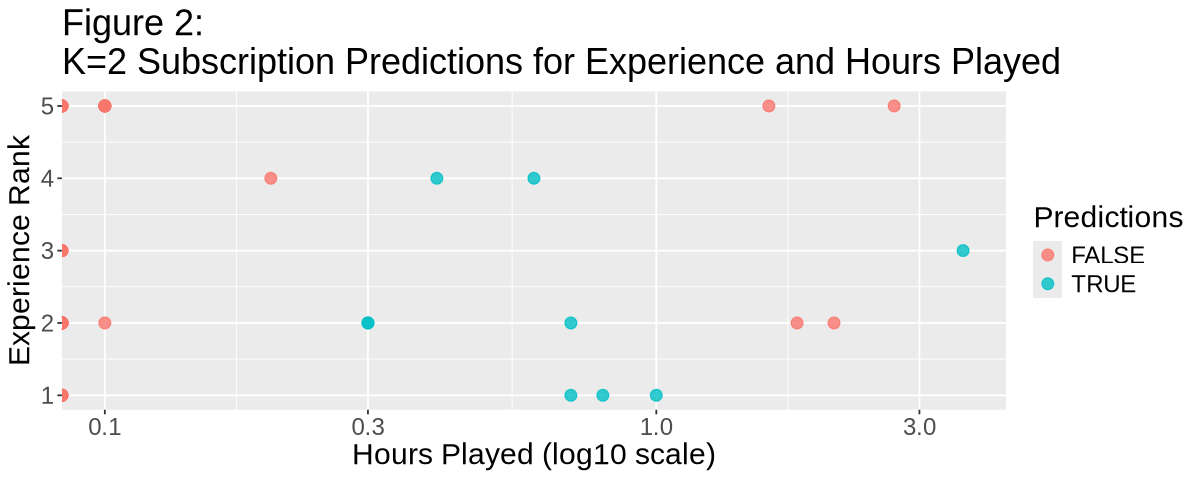

In [14]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)
k_2_preds <- predictions_2 |>
    ggplot(aes(x = played_hours, y = experience, color = .pred_class)) +
    geom_point(alpha = 0.8, size = 3) +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Predictions", title = "Figure 2:\nK=2 Subscription Predictions for Experience and Hours Played") +
    scale_x_log10() +
    theme(text = element_text(size = 18))
k_2_preds

**Figure 2:** On a logarithmic scale, this graph shows each observation in the testing dataset with our subscription predictions coloured. This, and the following two figures (3 and 4), aim to demonstrate the success of our model by juxtaposing our predictions with the actual `subscription` values.

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


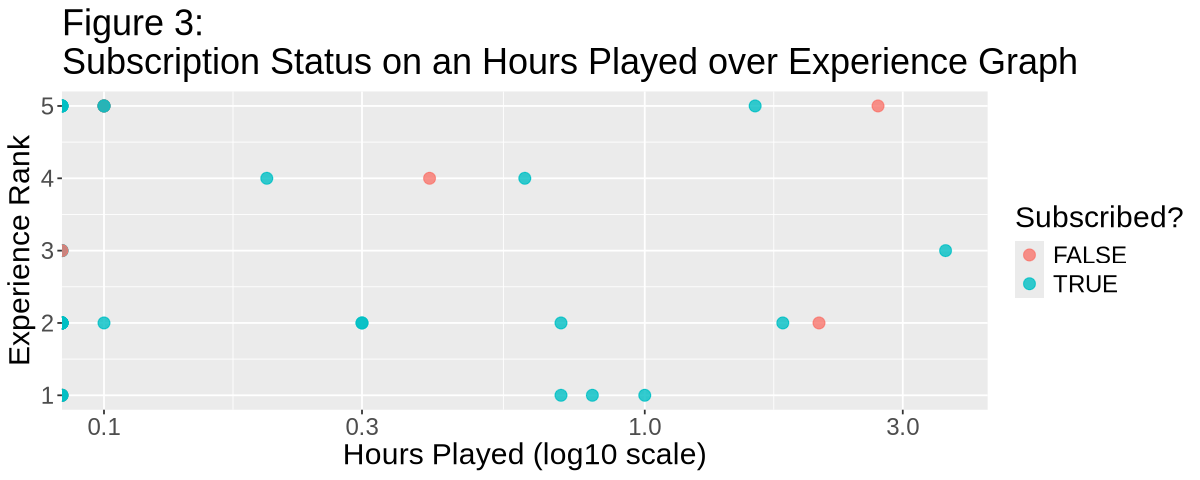

In [15]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)

k_reals_plotted <- players_testing |>
    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
    geom_point(alpha = 0.8, size = 3) +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Subscribed?", title = "Figure 3:\nSubscription Status on an Hours Played over Experience Graph") +
    scale_x_log10() +
    theme(text = element_text(size = 18))
k_reals_plotted

**Figure 3:** On a logarithmic scale, this graph shows each observation in the testing dataset with the *actual* subscription status coloured.

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


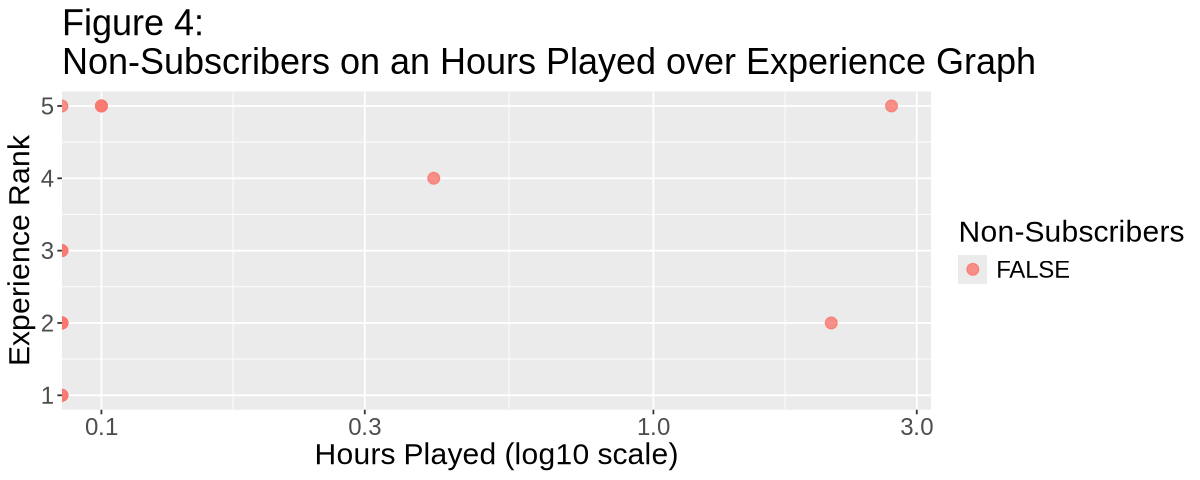

In [16]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)

k_falses_plotted <- players_testing |>
    filter(subscribe == "FALSE") |>
    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
    geom_point(alpha = 0.8, size = 3) +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Non-Subscribers", title = "Figure 4:\nNon-Subscribers on an Hours Played over Experience Graph") +
    scale_x_log10() +
    theme(text = element_text(size = 18))
k_falses_plotted

**Figure 4:** On a logarithmic scale, this graph shows the *false* observations ONLY in the testing dataset.

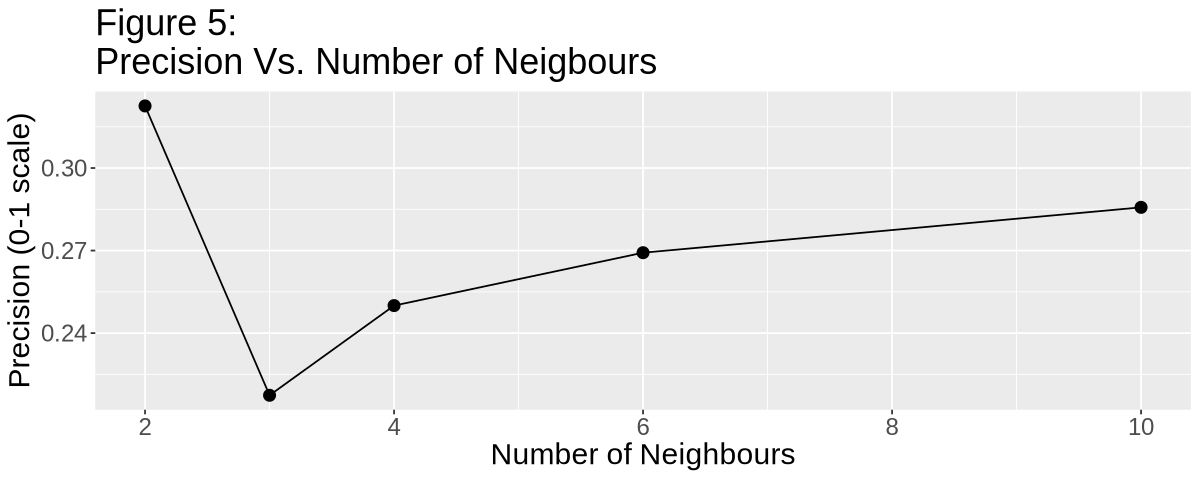

In [17]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)

precision_plot <- ggplot (metrics_df, aes(x = k, y = precision)) +
                    geom_point(size = 3) +
                    geom_line() +
                    labs(x = "Number of Neighbours",
                         y = "Precision (0-1 scale)") +
                    ggtitle ("Figure 5:\nPrecision Vs. Number of Neigbours") +
                    theme(text = element_text(size = 18))
precision_plot   

**Figure 5:** This graph shows how our precision metric changes with the number of neighbours used (value for *k*). We chose these variables to illustrate which *k*s perform better for our model in terms of precision. Precision is on a 0-1 scale and represents the ratio of correct non-subscription predictions to total non-subscription predictions.

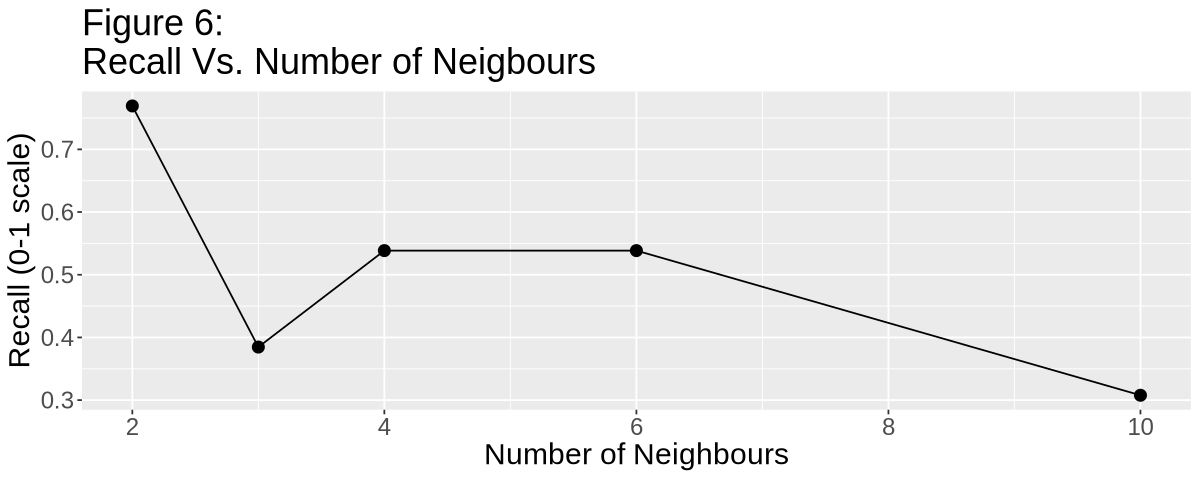

In [18]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)

recall_plot <- ggplot (metrics_df, aes(x = k, y = recall)) +
                    geom_point(size = 3) +
                    geom_line() +
                    labs(x = "Number of Neighbours",
                         y = "Recall (0-1 scale)") +
                    ggtitle ("Figure 6:\nRecall Vs. Number of Neigbours") +
                    theme(text = element_text(size = 18))
recall_plot

**Figure 6:** This graph shows how our recall metric (the one we are trying to optimize) changes with the number of neighbours used (value for *k*). We can see that k = 2 does the best job of predicting non-subscribers using `experience` and `played_hours`. Recall is on a 0-1 scale and represents the ratio of correct non-subscription predictions to total non-subscriptions.

## Discussion
   
With our goal of predicting `subscribe` using `experience` and `played_hours` in a K-NN workflow, we produced a model with an optimal k (2 nearest neighbours) and 77% recall value. After splitting the data, we first created a cross-validation k-tuning model to evaluate accuracy with k. In addition to this model being messy (it failed to produce a clear best k value with upsampled data and worked best with an infinite value for k without upsampling), it also failed to capture the important aspects of the inquiry question. We figured developers would be most interested in non-subscribers, so they could figure out why people are not subscribing and offer subscription incentives that would cater to non-subscribers in efforts to get as many people subscribed as possible. Thus, we felt it made sense for our model to sophistocatedly predict which people were not subscribed, and accordingly chose recall as the primary metric we would optimize for. A high recall ensures that when the model predicts someone as a non-subscriber, it is likely correct, minimizing misclassification. After trying multiple ks, we produced precision and recall values in a data frame and selected the k with the highest recall. Although recall was our primary metric, we monitored precision to ensure the model was not only reliable in one metric. Since precision was also highest at k=2, it was a good value to use. 

Returning to our exploratory visualizations, we hypothesized that Regular (experience rank = 3) players were likely to be the most prevalent subscribers. This was somewhat undercut by the fact our testing set only took 2 observations in that category. An explanation for this could be that not many users self-reported as having a normal amount of experience, or our testing set could have done a poor job of representing the number of Regular observations in the data.

While we have obtained some useful findings, we have also identified user behavioral issues that cannot be fully explained by the existing data and deserve further research. A result of 77% is reasonable, and roughly what we could expect since our classes were so imbalanced. Considering it is significantly more than 50%, this data is useful to the developers, as they can successfully predict about 3 of 4 non-subscribers based on how much they've played and use that data to learn about which people do not subscribe. From Figure 2, we see that the biggest cluster of predicted non-subscribers were those who had played very few hours in PLAICraft, regardless of MineCraft experience. This is a reasonable assumption to make; those who have invested very little of their time into this project are least likely to subscribe, irrespective of their passion for MineCraft. While `played_hours` was the most strongly related feature, we also included the variable `experience`, which contributed marginally to the model’s performance. This is logical as `experience` is a self-reported category, and therefore is variable to personal bias. What is more interesting, however, is the second cluster of non-subscribers at the high end of hours played in PLAICraft. Based on our metrics (which are a rough gauge of commitment to the project), there is no reason why they should not have subscribed, and further efforts to figure out why they have not subscribed would make for impactful marketing research. This is likely the biggest impact of our model; we've predicted a cluster of high-commitment non-subscribers, and this logical discrepancy demands more research. Perhaps there are other factors at play; maybe these players are very young and won't receive emails, or perhaps their hours count is unusually high because they leave the game on in the background. **These hypotheses could lead to new data analysis that seeks to unpack exclusively that cluster and explain it.**  

Finally, although our results lead to some interesting questions, they are hampered by the size and content of the data available. We only have 196 observations with 7 variables being tracked, and small data allows anomalies to bear more weight. We also can't perform analysis on variables like "How often do they check their email" or "How many other newsletters are they subscribed to," which means our results must be produced strictly by what we have access to. Although our model is clearly functional, 77% is not overly powerful, and indeed, the cluster of high-commitment non-subscribers contains two fewer observations than our model suggests. While it is worth investigating, we need more data and a better model before we can pursue other questions related exclusively to that cluster.  
**In summation, here are a few ways to improve the performance of our model:**  
1. **Richer behavioral data** <br>
   Examples: Past subscription behavior in similar games, device type or platform, in-game purchase history...  
2. **Demographic information** <br>
   Examples: Language spoken  
3. **Larger and more diverse dataset** <br> 
The current dataset contains only 196 observations, which may limit the generalizability and reliability of our findings. Future efforts may focus on inviting more players to PLAICraft or collecting data over a longer period of time. Larger datasets allow for more accurate modeling, better cross-validation, and may reveal patterns not visible in small samples.